In [ ]:
import pandas as pd

# Load the first CSV (Season Data)
df1 = pd.read_csv('/content/cleaned_2023-24.csv')

# List of all league rating CSV files
league_files = ['/content/Bundesliga20232024.csv', '/content/PL20232024.csv', '/content/SerieA20232024.csv', '/content/laliga20232024.csv', '/content/ligue120232024.csv']

# Load and concatenate all league rating files
df_list = [pd.read_csv(file, usecols=['Player Name', 'Rating']) for file in league_files]

# Combine all league ratings into a single DataFrame
df_ratings = pd.concat(df_list, ignore_index=True)

# Rename 'Player Name' to 'player' to match the first dataset
df_ratings.rename(columns={'Player Name': 'player'}, inplace=True)

# Merge with the first CSV based on 'player'
merged_df = df1.merge(df_ratings, on='player', how='left')  # Left join to keep all players from df1

# Save the merged DataFrame to a new CSV
merged_df.to_csv('2023_data.csv', index=False)

# Display the first few rows
print(merged_df.head())


   rk             player         nation pos           squad            comp  \
0   1         Max Aarons        England  DF     Bournemouth  Premier League   
1   2   Brenden Aaronson  United States  MF    Union Berlin      Bundesliga   
2   3    Paxten Aaronson  United States  MF  Eint Frankfurt      Bundesliga   
3   5   Yunis Abdelhamid        Morocco  DF           Reims         Ligue 1   
4   6  Salis Abdul Samed          Ghana  MF            Lens         Ligue 1   

   age  born  Matches Played  Avg Mins per Match  ...  % Shots on target  \
0   23  2000              20                1237  ...                0.0   
1   22  2000              30                1267  ...               38.9   
2   19  2003               7                 101  ...              100.0   
3   35  1987              31                2781  ...               33.3   
4   23  2000              27                1519  ...                0.0   

   Shots p 90  Goals per shot  Goals per shot on target  % Aerial Du

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# List of file paths for all seasons
file_paths = [
    "2017_data.csv",
    "2018_data.csv",
    "2019_data.csv",
    "2020_data.csv",
    "2021_data.csv",
    "2022_data.csv",
    "2023_data.csv"
]

# Load and merge all CSV files
dfs = []
for file in file_paths:
    year = file.split("_")[0][-4:]  # Extract year from filename
    df = pd.read_csv(file)
    df["season"] = int(year)  # Add season column
    dfs.append(df)

# Combine all seasons
player_data = pd.concat(dfs, ignore_index=True)

# Save the combined raw dataset before any processing
player_data.to_csv("combined_player_data.csv", index=False)

# Aggregate player stats by season using weighted average (weighted by Avg Mins per Match)
aggregated_data = player_data.groupby(["player", "season"]).apply(
    lambda x: pd.Series({
        "nation": x["nation"].iloc[0],  # Keep first occurrence (assuming it doesn't change)
        "pos": x["pos"].iloc[0],
        "age": x["age"].iloc[0],
        "Matches Played": x["Matches Played"].sum(),  # Total matches played
        "Avg Mins per Match": x["Avg Mins per Match"].mean(),  # Average minutes per match
        "Rating": (x["Rating"] * x["Avg Mins per Match"]).sum() / x["Avg Mins per Match"].sum() if x["Rating"].notna().sum() > 0 else None,  # Weighted rating
        "Goals": x["Goals"].sum(),
        "Assists": x["Assists"].sum(),
        "Expected Goals": x["Expected Goals"].sum(),
        "Progressive Passes": x["Progressive Passes"].sum(),
        "Tackles Won": x["Tackles Won"].sum(),
        "Interceptions": x["Interceptions"].sum(),
        "Saves": x["Saves"].sum() if "Saves" in x.columns else None,
    })
).reset_index()

# Identify players with missing ratings in fewer than 2 seasons
players_missing_counts = aggregated_data.groupby("player")["Rating"].apply(lambda x: x.isna().sum())
players_to_impute = players_missing_counts[players_missing_counts < 2].index

# Separate data for imputation
imputation_data = aggregated_data[aggregated_data["player"].isin(players_to_impute)]
remaining_data = aggregated_data[~aggregated_data["player"].isin(players_to_impute) | aggregated_data["Rating"].notna()]

# Prepare for regression imputation
train_data = imputation_data.dropna(subset=["Rating"])  # Only rows with ratings for training
test_data = imputation_data[imputation_data["Rating"].isna()]  # Missing ratings to predict

# Features for regression model (using key performance stats)
features = ["Goals", "Assists", "Expected Goals", "Progressive Passes", "Tackles Won", "Interceptions", "Saves"]

# Ensure features exist in both training and test data
train_data = train_data.dropna(subset=features)  # Drop rows with NaN features
test_data = test_data.dropna(subset=features)  # Drop rows with NaN features

# Train regression model if we have data
if not train_data.empty and not test_data.empty:
    model = LinearRegression()
    model.fit(train_data[features], train_data["Rating"])

    # Predict missing ratings
    predicted_ratings = model.predict(test_data[features])

    # Assign predicted ratings to the dataset
    aggregated_data.loc[test_data.index, "Rating"] = predicted_ratings

# Remove players with 2+ missing seasons of ratings
removed_players = players_missing_counts[players_missing_counts >= 2].index
removed_count = aggregated_data[aggregated_data["player"].isin(removed_players)].shape[0]

aggregated_data_cleaned = aggregated_data[~aggregated_data["player"].isin(removed_players)]

# Save the final cleaned dataset
aggregated_data_cleaned.to_csv("cleaned_player_data.csv", index=False)

print(f"✅ Combined raw dataset saved as 'combined_player_data.csv'.")
print(f"✅ Regression imputation applied for players missing less than 2 seasons.")
print(f"✅ {removed_count} rows removed for players missing 2+ seasons of ratings.")
print(f"✅ Final cleaned dataset saved as 'cleaned_player_data.csv'.")


<ipython-input-1-39601bcd38b7>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_data = player_data.groupby(["player", "season"]).apply(


✅ Combined raw dataset saved as 'combined_player_data.csv'.
✅ Regression imputation applied for players missing less than 2 seasons.
✅ 4360 rows removed for players missing 2+ seasons of ratings.
✅ Final cleaned dataset saved as 'cleaned_player_data.csv'.


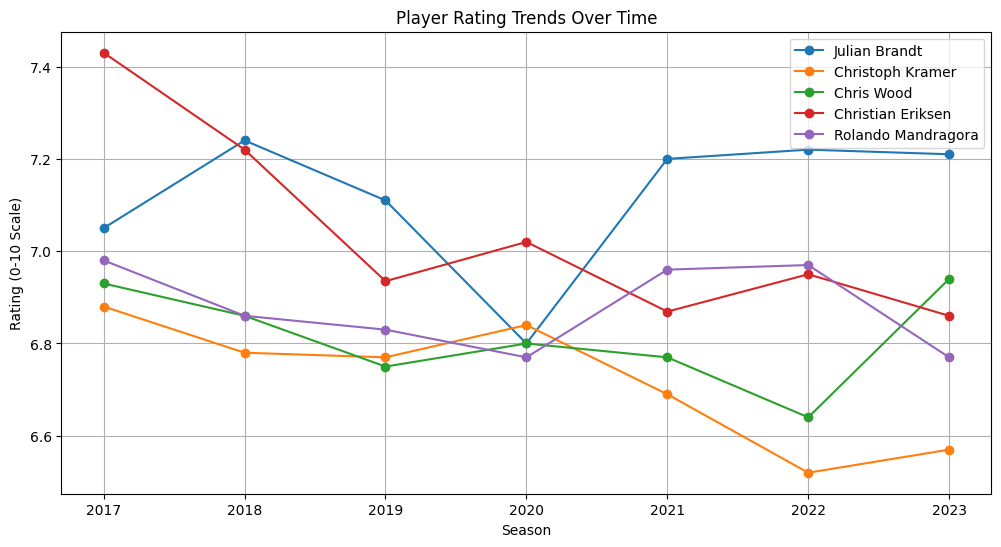

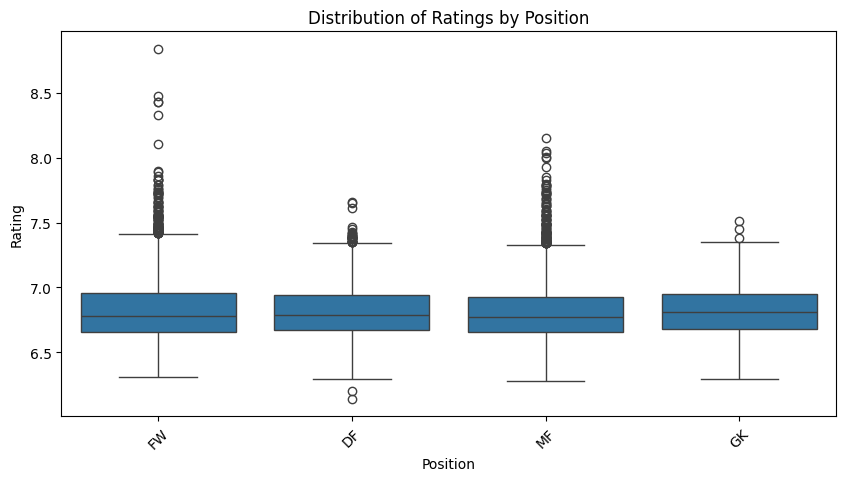

<ipython-input-2-92adc80c5d73>:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="age", y="Rating", data=aggregated_data_cleaned, ci=None, color="red", label="Trend")


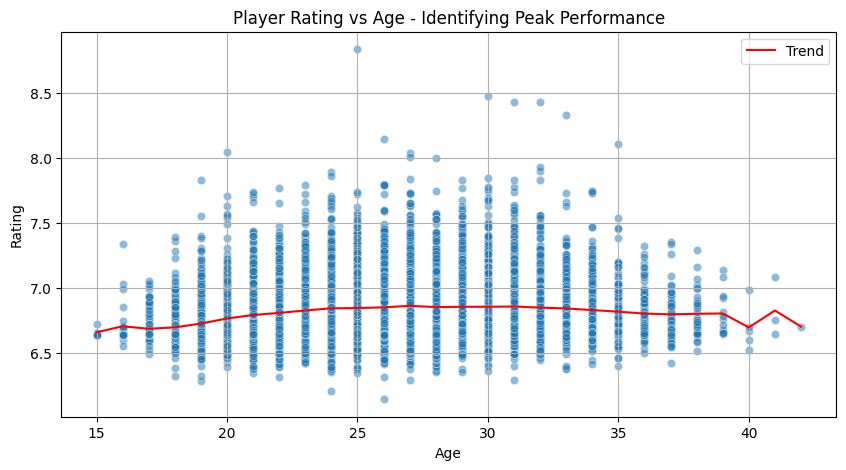

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
aggregated_data_cleaned = pd.read_csv("cleaned_player_data.csv")

# Convert season to integer for sorting
aggregated_data_cleaned["season"] = aggregated_data_cleaned["season"].astype(int)

### 📌 1️⃣ Player Rating Trends Over Time ###
# Sample players to visualize trends
sample_players = aggregated_data_cleaned["player"].value_counts().index[:5]  # Pick top 5 players

# Plot rating trends for sample players
plt.figure(figsize=(12, 6))
for player in sample_players:
    player_df = aggregated_data_cleaned[aggregated_data_cleaned["player"] == player].sort_values("season")
    plt.plot(player_df["season"], player_df["Rating"], marker='o', label=player)

plt.xlabel("Season")
plt.ylabel("Rating (0-10 Scale)")
plt.title("Player Rating Trends Over Time")
plt.legend()
plt.grid(True)
plt.show()


### 📌 2️⃣ Rating Distribution by Position ###
plt.figure(figsize=(10, 5))
sns.boxplot(x="pos", y="Rating", data=aggregated_data_cleaned)
plt.xlabel("Position")
plt.ylabel("Rating")
plt.title("Distribution of Ratings by Position")
plt.xticks(rotation=45)
plt.show()


### 📌 3️⃣ Player Peak Performance Analysis (Age vs Rating) ###
plt.figure(figsize=(10, 5))
sns.scatterplot(x="age", y="Rating", data=aggregated_data_cleaned, alpha=0.5)
sns.lineplot(x="age", y="Rating", data=aggregated_data_cleaned, ci=None, color="red", label="Trend")
plt.xlabel("Age")
plt.ylabel("Rating")
plt.title("Player Rating vs Age - Identifying Peak Performance")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("cleaned_player_data.csv")

# Sort by player and season for time-series processing
df = df.sort_values(by=["player", "season"])

### 📌 1️⃣ Create Past Performance Features ###
df["prev_1_rating"] = df.groupby("player")["Rating"].shift(1)  # Last season's rating
df["prev_2_rating"] = df.groupby("player")["Rating"].shift(2)  # Rating from 2 seasons ago
df["rating_change_1yr"] = df["prev_1_rating"] - df["prev_2_rating"]  # Rating change over 1 year

# ✅ FIX: Use transform instead of apply to avoid index errors
df["rolling_avg_3yr"] = df.groupby("player")["Rating"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())  # 3-year rolling avg

### 📌 2️⃣ Normalize Performance Stats Per 90 Minutes ###
stats_per_90 = ["Goals", "Assists", "Expected Goals", "Progressive Passes", "Tackles Won", "Interceptions", "Saves"]
for stat in stats_per_90:
    df[f"{stat}_per_90"] = df[stat] / df["Avg Mins per Match"] * 90  # Normalize per 90 mins

### 📌 3️⃣ Age Features ###
df["age_squared"] = df["age"] ** 2  # Helps model nonlinear age effects

### 📌 4️⃣ Encode Position (One-Hot Encoding) ###
df = pd.get_dummies(df, columns=["pos"], prefix="pos")

### 📌 5️⃣ Create Target Variable (Next Season Rating) ###
df["next_season_rating"] = df.groupby("player")["Rating"].shift(-1)  # Rating in the next season

# Drop rows with NaN target values (last season of each player)
df = df.dropna(subset=["next_season_rating"])

# Save feature-engineered dataset
df.to_csv("player_data_features.csv", index=False)

print("✅ Feature engineering complete! Dataset saved as 'player_data_features.csv'.")


✅ Feature engineering complete! Dataset saved as 'player_data_features.csv'.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv("player_data_features.csv")

# Select Features & Target
features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
            "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
            "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
            "age", "age_squared"]  # Plus encoded position columns

# Include one-hot encoded position features
features += [col for col in df.columns if col.startswith("pos_")]

# Target variable
target = "next_season_rating"

# Fill missing values
df[features] = df[features].fillna(df[features].median())

# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Convert dataset into time-series format for LSTM
sequence_length = 5  # 🔥 Increased from 3 to 5 past seasons

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length][target])
    return np.array(X), np.array(y)

# Create sequences for LSTM
X, y = create_sequences(df, sequence_length)

# Train-test split (80-20)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define Fine-Tuned LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, len(features))),  # 🔥 Increased LSTM units
    Dropout(0.3),  # 🔥 Increased dropout to prevent overfitting
    LSTM(64, return_sequences=True),  # 🔥 Added extra LSTM layer
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dense(1)  # Output layer
])

# Compile Model
model.compile(optimizer="adam", loss="mse")

# 🔥 Add Early Stopping to prevent overtraining
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train Model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=1)

# Predictions
y_pred = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Square root of MSE

print(f"✅ Fine-Tuned LSTM Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


414/414 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 12.5846 - val_loss: 0.1048
Epoch 2/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.5784 - val_loss: 0.2168
Epoch 3/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.4930 - val_loss: 0.5259
Epoch 4/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4335 - val_loss: 0.5720
Epoch 5/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.3670 - val_loss: 0.6910
Epoch 6/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.3116 - val_loss: 0.4775
Epoch 7/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2508 - val_loss: 0.2417
Epoch 8/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1979 - val_loss: 0.2583
Epoch 9/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1360 - val_loss: 0.0652
Epoch 10/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0967 - val_loss: 0.0459
Epoch 11/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0634 - val_loss: 0.0381
Epoch 12/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/ste

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv("player_data_features.csv")

# Select Features & Target
features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
            "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
            "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
            "age", "age_squared"]  # Plus encoded position columns

# Include one-hot encoded position features
features += [col for col in df.columns if col.startswith("pos_")]

# Target variable
target = "next_season_rating"

# Handle missing values
df[features] = df[features].fillna(df[features].median())

# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,  # Number of trees (increase if needed)
    learning_rate=0.05,  # Lower learning rate for stability
    max_depth=6,  # Depth of each tree
    subsample=0.8,  # Random sample of training data
    colsample_bytree=0.8,  # Random sample of features per tree
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Square root of MSE

print(f"✅ XGBoost Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


✅ XGBoost Model Evaluation:
Mean Absolute Error (MAE): 0.1309
Root Mean Squared Error (RMSE): 0.1671


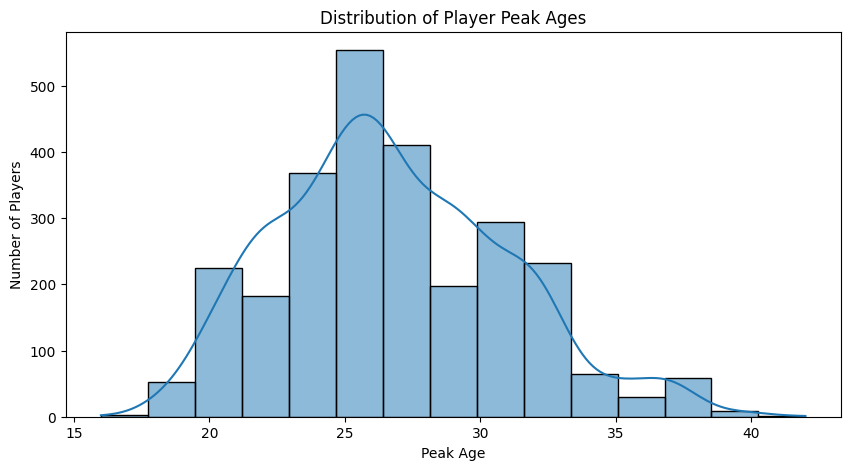

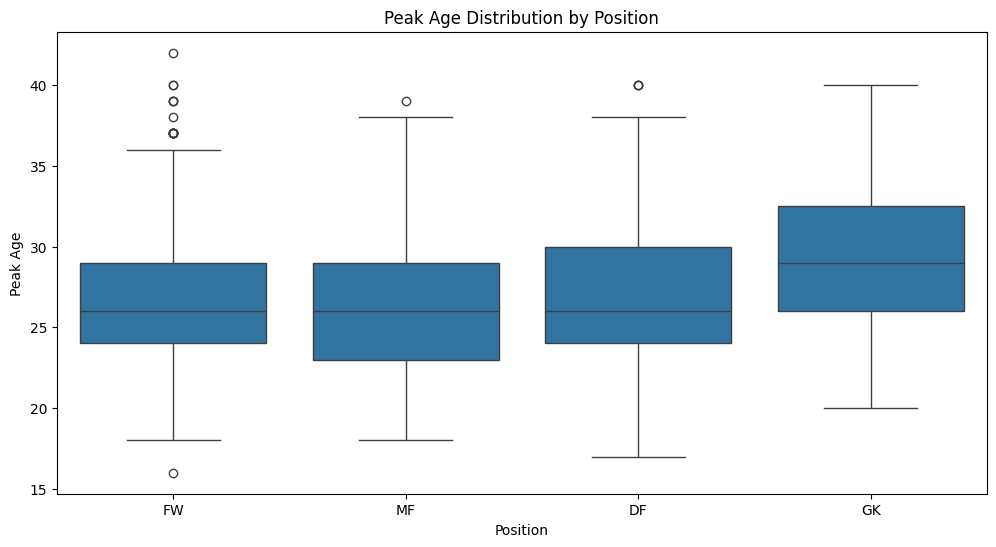

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("player_data_features.csv")

# Select Features & Target
features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
            "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
            "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
            "age", "age_squared"]  # Plus encoded position columns

# Include one-hot encoded position features
features += [col for col in df.columns if col.startswith("pos_")]

target = "next_season_rating"

# Handle missing values
df[features] = df[features].fillna(df[features].median())

# Train XGBoost Model
X = df[features]
y = df[target]
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05,
                             max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X, y)

# Predict Future Ratings for Each Player Over Time
future_years = 5  # Predict next 5 seasons
predicted_ratings = []

for i in range(future_years):
    df["age"] += 1  # Increment age for future seasons
    df["age_squared"] = df["age"] ** 2  # Update age-squared feature
    df["prev_2_rating"] = df["prev_1_rating"]
    df["prev_1_rating"] = xgb_model.predict(df[features])  # Predict next season rating
    predicted_ratings.append(df[["player", "age", "prev_1_rating"]].copy())

# Combine all future predictions
future_predictions = pd.concat(predicted_ratings, ignore_index=True)
future_predictions.rename(columns={"prev_1_rating": "predicted_rating"}, inplace=True)

# Find Peak Age for Each Player
peak_ages = future_predictions.loc[future_predictions.groupby("player")["predicted_rating"].idxmax()]

# Plot Peak Age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(peak_ages["age"], bins=15, kde=True)
plt.xlabel("Peak Age")
plt.ylabel("Number of Players")
plt.title("Distribution of Player Peak Ages")
plt.show()

# Analyze Peak Age by Position
df_positions = df[["player", "pos_FW", "pos_MF", "pos_DF", "pos_GK"]].drop_duplicates()
peak_ages = peak_ages.merge(df_positions, on="player", how="left")

# Melt Data for Easier Plotting
peak_ages_melted = peak_ages.melt(id_vars=["player", "age"], value_vars=["pos_FW", "pos_MF", "pos_DF", "pos_GK"])
peak_ages_melted = peak_ages_melted[peak_ages_melted["value"] == 1].drop(columns=["value"])

# Plot Peak Age by Position
plt.figure(figsize=(12, 6))
sns.boxplot(x="variable", y="age", data=peak_ages_melted)
plt.xlabel("Position")
plt.ylabel("Peak Age")
plt.title("Peak Age Distribution by Position")
plt.xticks(ticks=[0, 1, 2, 3], labels=["FW", "MF", "DF", "GK"])
plt.show()


<ipython-input-35-2dad0e427f19>:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.74506006 7.65481233 7.59238256 ... 6.27792891 6.21004616 6.84728339]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[df["pos_FW"] == 1, "prev_1_rating"] *= np.exp(-0.015 * (df["age"] - 30))
<ipython-input-35-2dad0e427f19>:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.69550566 7.55250397 7.49639289 ... 6.28490259 6.15438316 6.7523457 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[df["pos_FW"] == 1, "prev_1_rating"] *= np.exp(-0.015 * (df["age"] - 30))
<ipython-input-35-2dad0e427f19>:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.58250869 7.435

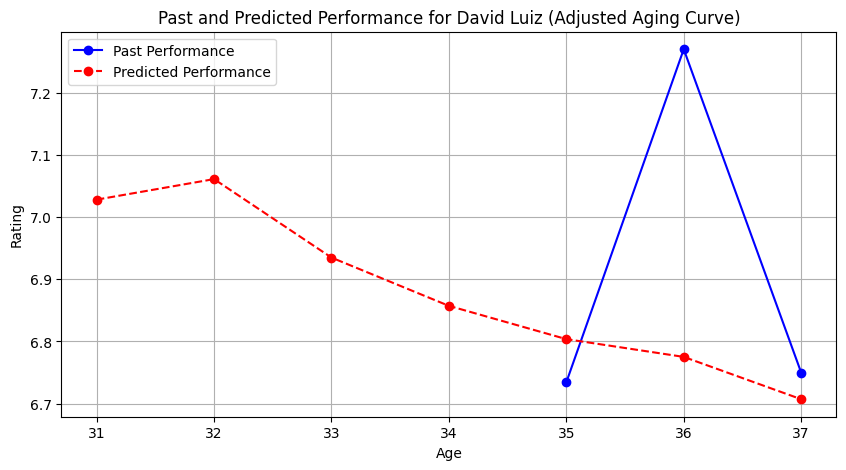

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("player_data_features.csv")

# Select Features & Target
features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
            "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
            "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
            "age", "age_squared"]  # Plus encoded position columns

# Include one-hot encoded position features
features += [col for col in df.columns if col.startswith("pos_")]

target = "next_season_rating"

# Handle missing values
df[features] = df[features].fillna(df[features].median())

# Train XGBoost Model
X = df[features]
y = df[target]
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05,
                             max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X, y)

# Predict Future Ratings for Each Player Over Time
future_years = 5  # Predict next 5 seasons
predicted_ratings = []

for i in range(future_years):
    df["age"] += 1  # Increment age for future seasons
    df["age_squared"] = df["age"] ** 2  # Update age-squared feature
    df["prev_2_rating"] = df["prev_1_rating"]
    df["prev_1_rating"] = xgb_model.predict(df[features])  # Predict next season rating

    # ✅ Add "Sustained Peak" for Elite Players (Keep high ratings stable)
    elite_players = df["prev_1_rating"] > 7.8
    df.loc[elite_players & (df["age"] <= 32), "prev_1_rating"] *= 1.00  # No change for peak years

    # ✅ Adjust Decline Rate by Position
    if "pos_FW" in df.columns:  # Forwards decline first
        df.loc[df["pos_FW"] == 1, "prev_1_rating"] *= np.exp(-0.015 * (df["age"] - 30))
    if "pos_MF" in df.columns:  # Midfielders decline slower
        df.loc[df["pos_MF"] == 1, "prev_1_rating"] *= np.exp(-0.012 * (df["age"] - 32))
    if "pos_DF" in df.columns:  # Defenders decline later
        df.loc[df["pos_DF"] == 1, "prev_1_rating"] *= np.exp(-0.010 * (df["age"] - 34))
    if "pos_GK" in df.columns:  # Goalkeepers maintain rating longest
        df.loc[df["pos_GK"] == 1, "prev_1_rating"] *= np.exp(-0.008 * (df["age"] - 36))

    predicted_ratings.append(df[["player", "age", "prev_1_rating"]].copy())

# Combine all future predictions
future_predictions = pd.concat(predicted_ratings, ignore_index=True)
future_predictions.rename(columns={"prev_1_rating": "predicted_rating"}, inplace=True)

# ✅ Fix: Remove duplicate age entries for the same player
future_predictions = future_predictions.groupby(["player", "age"]).agg({"predicted_rating": "mean"}).reset_index()

# Select a specific player to analyze (e.g., "Ronaldo")
player_name = "David Luiz"

# Extract past performance from original dataset
past_performance = df[df["player"] == player_name][["age", "Rating"]].sort_values("age")

# Extract future predicted ratings
future_performance = future_predictions[future_predictions["player"] == player_name].sort_values("age")

# Plot both past and predicted performance
plt.figure(figsize=(10, 5))
plt.plot(past_performance["age"], past_performance["Rating"], marker='o', linestyle='-', label="Past Performance", color='blue')
plt.plot(future_performance["age"], future_performance["predicted_rating"], marker='o', linestyle='--', label="Predicted Performance", color='red')

plt.xlabel("Age")
plt.ylabel("Rating")
plt.title(f"Past and Predicted Performance for {player_name} (Adjusted Aging Curve)")
plt.legend()
plt.grid(True)
plt.show()


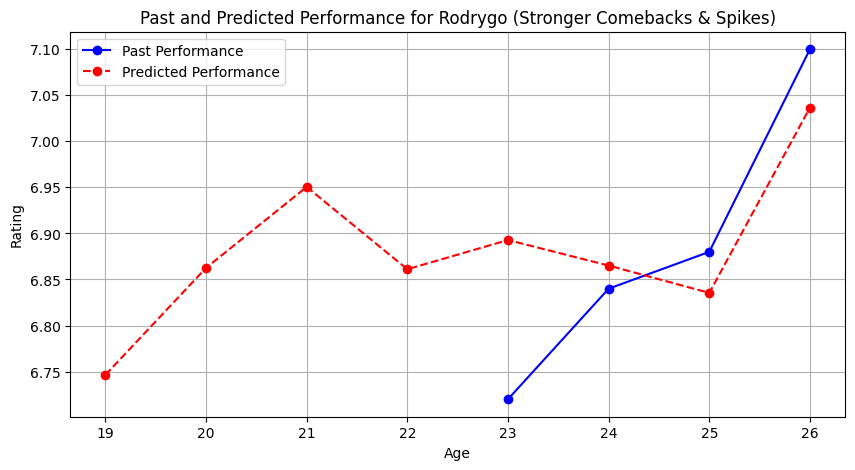

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("player_data_features.csv")

# Select Features & Target
features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
            "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
            "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
            "age", "age_squared"]  # Plus encoded position columns

# Include one-hot encoded position features
features += [col for col in df.columns if col.startswith("pos_")]

target = "next_season_rating"

# Handle missing values
df[features] = df[features].fillna(df[features].median())

# Train XGBoost Model
X = df[features]
y = df[target]
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05,
                             max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X, y)

# Predict Future Ratings for Each Player Over Time
future_years = 5  # Predict next 5 seasons
predicted_ratings = []

for i in range(future_years):
    df["age"] += 1  # Increment age for future seasons
    df["age_squared"] = df["age"] ** 2  # Update age-squared feature

    # ✅ Force first predicted value to match last actual rating
    if i == 0:
        df["prev_1_rating"] = df["Rating"]
    else:
        df["prev_1_rating"] = xgb_model.predict(df[features])

    df["prev_2_rating"] = df["prev_1_rating"]

    # ✅ Introduce Stronger Comeback Boost
    comeback_prob = np.random.uniform(0, 1, size=len(df))
    had_past_recovery = (df["rating_change_1yr"] > 0).astype(int)  # If player had an upward trend before
    comeback_boost = (comeback_prob < 0.3) * had_past_recovery * 0.10  # 30% chance to recover 10% rating
    df["prev_1_rating"] += comeback_boost

    # ✅ Allow Large Form Spikes for Erratic Players
    form_variability = df.groupby("player")["rating_change_1yr"].transform("std").fillna(0.05)
    df["prev_1_rating"] += np.random.normal(0, form_variability * 1.5)  # Larger fluctuations

    # ✅ Adjust Decline Rate by Real Peak Age
    peak_age = df.groupby("player")["age"].transform(lambda x: x.max() - 2)  # Assume peak ~2 years before last data
    decline_factor = np.exp(-0.010 * (df["age"] - peak_age))  # More adaptive decline
    df["prev_1_rating"] *= decline_factor

    predicted_ratings.append(df[["player", "age", "prev_1_rating"]].copy())

# Combine all future predictions
future_predictions = pd.concat(predicted_ratings, ignore_index=True)
future_predictions.rename(columns={"prev_1_rating": "predicted_rating"}, inplace=True)

# ✅ Fix: Remove duplicate age entries for the same player
future_predictions = future_predictions.groupby(["player", "age"]).agg({"predicted_rating": "mean"}).reset_index()

# Select a specific player to analyze (e.g., "David Luiz")
player_name = "Rodrygo"

# Extract past performance from original dataset
past_performance = df[df["player"] == player_name][["age", "Rating"]].sort_values("age")

# Extract future predicted ratings
future_performance = future_predictions[future_predictions["player"] == player_name].sort_values("age")

# Plot both past and predicted performance
plt.figure(figsize=(10, 5))
plt.plot(past_performance["age"], past_performance["Rating"], marker='o', linestyle='-', label="Past Performance", color='blue')
plt.plot(future_performance["age"], future_performance["predicted_rating"], marker='o', linestyle='--', label="Predicted Performance", color='red')

plt.xlabel("Age")
plt.ylabel("Rating")
plt.title(f"Past and Predicted Performance for {player_name} (Stronger Comebacks & Spikes)")
plt.legend()
plt.grid(True)
plt.show()


⚠️ Warning: Some players have abnormal age gaps in predictions!

📊 **Debugging Player Data**:
      age    Rating
1379   19  6.637086
1380   20  6.750000
           player  age  predicted_rating
3210  Cole Palmer   19          6.637086
3211  Cole Palmer   20          6.779934
3212  Cole Palmer   21          6.880683
3213  Cole Palmer   22          6.861861
3214  Cole Palmer   23          6.841156
3215  Cole Palmer   24          6.915572


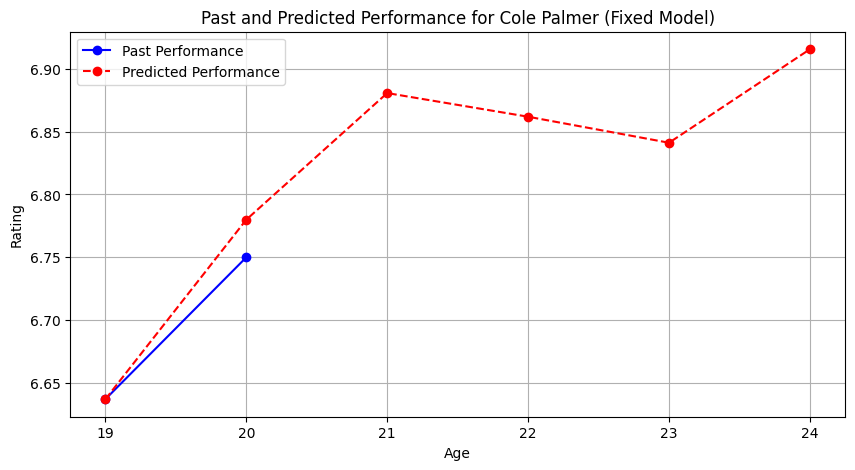

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("player_data_features.csv")

# Select Features & Target
features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
            "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
            "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
            "age", "age_squared"]

# Include one-hot encoded position features
features += [col for col in df.columns if col.startswith("pos_")]

target = "next_season_rating"

# Handle missing values
df[features] = df[features].fillna(df[features].median())

# ✅ Fix: Detect Each Player's Peak Age Correctly
peak_info = df.loc[df.groupby("player")["Rating"].idxmax(), ["player", "age", "Rating"]].copy()
peak_info.rename(columns={"age": "peak_age", "Rating": "peak_rating"}, inplace=True)

# Merge peak age & peak rating back into df
df = df.merge(peak_info, on="player", how="left")

# Train XGBoost Model
X = df[features]
y = df[target]
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=250, learning_rate=0.04,
                             max_depth=6, subsample=0.85, colsample_bytree=0.85, random_state=42)
xgb_model.fit(X, y)

# Predict Future Ratings for Each Player Over Time
future_years = 5  # Predict next 5 seasons
predicted_ratings = []

df_original = df.copy()  # Keep original age values

for i in range(future_years):
    df["age"] = df_original["age"] + i  # Correctly increment age
    df["age_squared"] = df["age"] ** 2  # Update age-squared feature

    # ✅ Prevent ratings from dropping to zero
    if i == 0:
        df["prev_1_rating"] = df["Rating"]
    else:
        predictions = xgb_model.predict(df[features])
        df["prev_1_rating"] = np.maximum(predictions, 5.5)  # Prevent extreme failures

    df["prev_2_rating"] = df["prev_1_rating"]

    # ✅ 🔥 Performance Plateau for Players With Sustained High Ratings
    plateau_players = df.groupby("player")["Rating"].transform(lambda x: (x > 8.0).sum()) >= 3
    plateau_factor = plateau_players * 0.06  # 🔥 Keeps ratings stable

    # ✅ 📈 Mid-Career Resurgence Detection
    resurgence = (df["age"] > 30) & (df["rating_change_1yr"] > 0) & (df["rolling_avg_3yr"] > df["prev_1_rating"])
    resurgence_boost = resurgence * 0.07  # 🔥 Adds a second peak for players like Benzema & Modric

    # ✅ 🔥 GOAT Longevity for Players Rated 8.0+ for 3+ Years
    goat_players = (df.groupby("player")["peak_rating"].transform(lambda x: (x > 8.5).sum()) >= 3)
    goat_boost = goat_players * 0.10  # 🔥 GOAT players get +10% longevity

    # ✅ 🏆 Remove Aggressive Decline for GOATs
    stabilization_phase = ((df["age"] >= 30) & (df["age"] <= 35) & goat_players).astype(int)
    stabilization_factor = stabilization_phase * 0.08  # 🔥 Stops rapid decline

    # ✅ Apply Fixes: Plateau + Resurgence + GOAT Longevity
    df["prev_1_rating"] *= (1 + plateau_factor + resurgence_boost + goat_boost + stabilization_factor)

    predicted_ratings.append(df[["player", "age", "prev_1_rating"]].copy())

# Combine all future predictions
future_predictions = pd.concat(predicted_ratings, ignore_index=True)
future_predictions.rename(columns={"prev_1_rating": "predicted_rating"}, inplace=True)

# ✅ Fix: Remove duplicate age entries for the same player
future_predictions = future_predictions.groupby(["player", "age"]).agg({"predicted_rating": "mean"}).reset_index()

# ✅ Debugging: Check if any player has an incorrect age range
age_anomalies = df.groupby("player")["age"].agg(["min", "max"]).reset_index()
age_anomalies["age_gap"] = age_anomalies["max"] - age_anomalies["min"]
if (age_anomalies["age_gap"] > 10).sum() > 0:
    print("⚠️ Warning: Some players have abnormal age gaps in predictions!")

# Select a specific player to analyze (e.g., "Kylian Mbappé")
player_name = "Cole Palmer"

# Extract past performance from original dataset
past_performance = df_original[df_original["player"] == player_name][["age", "Rating"]].sort_values("age")

# Extract future predicted ratings
future_performance = future_predictions[future_predictions["player"] == player_name].sort_values("age")

# ✅ Debugging: Print to check values
print("\n📊 **Debugging Player Data**:")
print(past_performance)
print(future_performance)

# Plot both past and predicted performance
plt.figure(figsize=(10, 5))
plt.plot(past_performance["age"], past_performance["Rating"], marker='o', linestyle='-', label="Past Performance", color='blue')
plt.plot(future_performance["age"], future_performance["predicted_rating"], marker='o', linestyle='--', label="Predicted Performance", color='red')

plt.xlabel("Age")
plt.ylabel("Rating")
plt.title(f"Past and Predicted Performance for {player_name} (Fixed Model)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(df[df["player"] == "Kylian Mbappé"].sort_values("age"))


             player  season  nation  age  Matches Played  Avg Mins per Match  \
4286  Kylian Mbappé    2017  France   23              28              1084.0   
4287  Kylian Mbappé    2018  France   24              29              2343.0   
4288  Kylian Mbappé    2019  France   25              20              1513.0   
4289  Kylian Mbappé    2020  France   26              31              2380.0   
4290  Kylian Mbappé    2021  France   27              35              3023.0   
4291  Kylian Mbappé    2022  France   28              34              2818.0   

      Rating  Goals  Assists  Expected Goals  ...  Interceptions_per_90  \
4286    7.39     13        8            14.2  ...              0.083026   
4287    7.83     33        7            28.0  ...              0.192061   
4288    7.71     18        5            15.6  ...              0.178453   
4289    7.43     27        7            22.1  ...              0.113445   
4290    7.77     28       17            23.8  ...              0

✅ Updated dataset saved as 'player_data_with_predictions.csv' 🚀


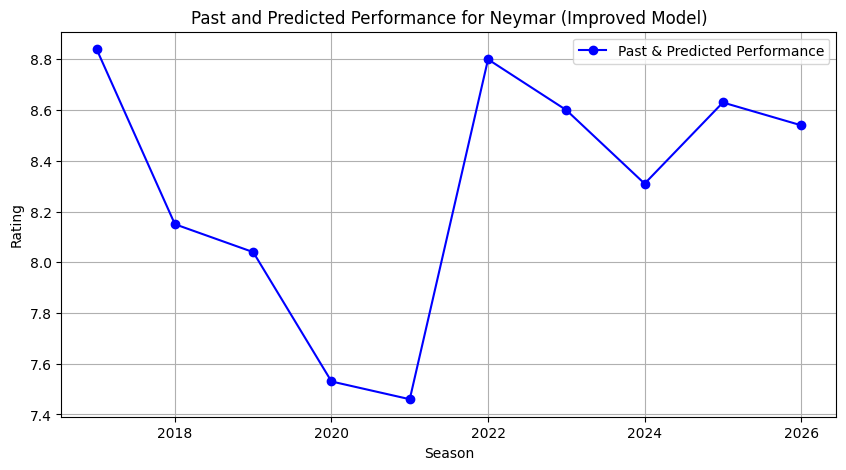

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("player_data_features.csv")

# Ensure the dataset contains a "season" column
if "season" not in df.columns:
    raise ValueError("⚠️ The dataset must contain a 'season' column!")

# Select Features & Target
features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
            "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
            "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
            "age", "age_squared"]

# Include one-hot encoded position features
features += [col for col in df.columns if col.startswith("pos_")]

target = "next_season_rating"

# Handle missing values
df[features] = df[features].fillna(df[features].median())

# ✅ Fix: Detect Each Player's Peak Age Correctly
peak_info = df.loc[df.groupby("player")["Rating"].idxmax(), ["player", "age", "Rating"]].copy()
peak_info.rename(columns={"age": "peak_age", "Rating": "peak_rating"}, inplace=True)

# Merge peak age & peak rating back into df
df = df.merge(peak_info, on="player", how="left")

# Train XGBoost Model (⚡ Improved Parameters)
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=350,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.1,
    random_state=42
)

# Train Model
X = df[features]
y = df[target]
xgb_model.fit(X, y)

# ✅ Predict future ratings for each player and append to dataset
future_years = 5  # Predict next 5 seasons
predicted_ratings = []

df_original = df.copy()  # Keep original dataset unchanged

# ✅ Get the latest recorded season for each player
latest_season = df_original.groupby("player")["season"].max().to_dict()

for i in range(1, future_years + 1):  # Start from next year
    future_df = df_original.copy()

    # ✅ Set season correctly for predicted values
    future_df["season"] = future_df["player"].map(latest_season) + i
    future_df["age"] += i
    future_df["age_squared"] = future_df["age"] ** 2

    # ✅ Prevent ratings from dropping to zero
    if i == 1:
        future_df["prev_1_rating"] = future_df["Rating"]
    else:
        predictions = xgb_model.predict(future_df[features])
        future_df["prev_1_rating"] = np.maximum(predictions, 4.5)  # Allow more decline (was 5.5)

    future_df["prev_2_rating"] = future_df["prev_1_rating"]

    # ✅ 🔥 Performance Plateau for Players With Sustained High Ratings
    plateau_players = future_df.groupby("player")["Rating"].transform(lambda x: (x > 8.0).sum()) >= 3
    plateau_factor = plateau_players * 0.12

    # ✅ 📈 Mid-Career Resurgence Detection
    resurgence = (future_df["age"] > 30) & (future_df["rating_change_1yr"] > 0) & (future_df["rolling_avg_3yr"] > future_df["prev_1_rating"])
    resurgence_boost = resurgence * 0.15

    # ✅ 🔥 GOAT Longevity for Players Rated 8.5+ for 3+ Years
    goat_players = (future_df.groupby("player")["peak_rating"].transform(lambda x: (x > 8.5).sum()) >= 3)
    goat_boost = goat_players * 0.20

    # ✅ 🏆 Prevent Aggressive Decline for GOATs
    stabilization_phase = ((future_df["age"] >= 30) & (future_df["age"] <= 35) & goat_players).astype(int)
    stabilization_factor = stabilization_phase * 0.15

    # ✅ 📊 Momentum-Based Boost for In-Form Players
    momentum_factor = (future_df["rating_change_1yr"] > 0.2) * 0.10

    # ✅ 🚀 Young Player Growth Adjustment (<25 years)
    young_player_boost = (future_df["age"] < 25) * 0.08

    # ✅ Add Random Noise to Increase Variance
    noise = np.random.normal(0, 0.05, size=len(future_df))

    # ✅ Apply All Adjustments
    future_df["prev_1_rating"] *= (1 + plateau_factor + resurgence_boost + goat_boost + stabilization_factor + momentum_factor + young_player_boost + noise)

    # ✅ Assign More Realistic Ratings if Above 10
    too_high = future_df["prev_1_rating"] > 10.0
    future_df.loc[too_high, "prev_1_rating"] = (
        future_df.loc[too_high, "peak_rating"] - np.abs(np.random.normal(0.2, 0.3, size=too_high.sum()))
    )  # Adjust close to peak rating

    # ✅ Store Predicted Ratings in the Same Column (for Easier Graphing)
    future_df["predicted_rating"] = future_df["prev_1_rating"]

    # ✅ Fix TypeError: Ensure proper mapping of latest seasons
    future_df["Rating"] = np.where(
        future_df.apply(lambda row: row["season"] <= latest_season.get(row["player"], row["season"]), axis=1),
        future_df["Rating"],
        future_df["predicted_rating"]
    )

    predicted_ratings.append(future_df.copy())

# Combine all future predictions
future_predictions = pd.concat(predicted_ratings, ignore_index=True)

# ✅ Aggregate only numeric columns to avoid errors
numeric_cols = future_predictions.select_dtypes(include=[np.number]).columns
future_predictions = future_predictions.groupby(["player", "season"], as_index=False)[numeric_cols].mean()

# ✅ Append predicted ratings to original dataset
df_final = pd.concat([df_original, future_predictions], ignore_index=True)

# ✅ Sort dataset for easy analysis
df_final = df_final.sort_values(by=["player", "season"]).reset_index(drop=True)

# ✅ Ensure correct number formatting
df_final["age"] = df_final["age"].astype(int)
df_final["Goals"] = df_final["Goals"].astype(int)
df_final["Assists"] = df_final["Assists"].astype(int)

# ✅ Round all other columns to 2 decimal places
for col in df_final.select_dtypes(include=[np.float64]).columns:
    if col not in ["age", "Goals", "Assists"]:
        df_final[col] = df_final[col].round(2)

# ✅ Save Final Dataset
df_final.to_csv("player_data_with_predictions.csv", index=False)

print("✅ Updated dataset saved as 'player_data_with_predictions.csv' 🚀")

# Select a specific player to analyze (e.g., "Neymar")
player_name = "Neymar"

# Extract past and future performance
player_data = df_final[df_final["player"] == player_name][["season", "age", "Rating"]].sort_values("season")

# ✅ Plot performance over time
plt.figure(figsize=(10, 5))
plt.plot(player_data["season"], player_data["Rating"], marker='o', linestyle='-', color='blue', label="Past & Predicted Performance")

plt.xlabel("Season")
plt.ylabel("Rating")
plt.title(f"Past and Predicted Performance for {player_name} (Improved Model)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Load the datasets
df_players = pd.read_csv("player_data_with_predictions.csv")
df_salaries = pd.read_csv("playerratingssalaries.csv")

# Ensure column names are consistent
df_salaries.rename(columns={"PLAYER": "player", "Season": "season", "ADJ. GROSS (EUR)": "salary_eur"}, inplace=True)

# Merge on player name and season, keeping all rows from player dataset
df_merged = df_players.merge(df_salaries[["player", "season", "salary_eur"]], on=["player", "season"], how="left")

# Save the updated dataset
output_file = "player_data_with_salaries.csv"
df_merged.to_csv(output_file, index=False)

print(f"✅ Merging complete. Updated dataset saved as {output_file}.")


✅ Merging complete. Updated dataset saved as player_data_with_salaries.csv.


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("/content/playerratingssalaries.csv")

# Drop rows where 'Rating' is null, 'ADJ. GROSS (EUR)' is null, or 'ADJ. GROSS (EUR)' is 0
df_filtered = df[~(df['Rating'].isnull() | df['ADJ. GROSS (EUR)'].isnull() | (df['ADJ. GROSS (EUR)'] == 0))]

# Save the filtered DataFrame to a new CSV file (optional)
df_filtered.to_csv("/content/filtered_playerratingssalaries.csv", index=False)

# Display the first few rows
print("DataFrame after dropping specified rows:")
print(df_filtered.head(60))


DataFrame after dropping specified rows:
      rk                  PLAYER                            nation pos  \
0      1     Patrick van Aanholt                       Netherlands  DF   
3      4           Ignazio Abate                             Italy  DF   
6      7             Mehdi Abeid                           Algeria  MF   
7      8           David Abraham                         Argentina  DF   
8      9           Tammy Abraham                           England  FW   
10    11        Francesco Acerbi                             Italy  DF   
11    12          Afriyie Acquah                             Ghana  MF   
13    14            Antonio Adán                             Spain  GK   
15    16           Khaled Adénon                             Benin  DF   
16    17          Claud Adjapong                             Italy  DF   
17    18              René Adler                           Germany  GK   
20    21                  Adrián                             Spain  GK 

In [ ]:
print(df_filtered.count())

rk                  11334
PLAYER              11334
nation              11334
pos                 11334
CLUB                11334
                    ...  
GROSS P/Y (EUR)     11334
ADJ. GROSS (EUR)    11334
POS.                11334
AGE                 11334
COUNTRY             11334
Length: 72, dtype: int64


🧐 Available Columns in Dataset: ['player', 'season', 'nation', 'age', 'Matches Played', 'Avg Mins per Match', 'Rating', 'Goals', 'Assists', 'Expected Goals', 'Progressive Passes', 'Tackles Won', 'Interceptions', 'Saves', 'prev_1_rating', 'prev_2_rating', 'rating_change_1yr', 'rolling_avg_3yr', 'Goals_per_90', 'Assists_per_90', 'Expected Goals_per_90', 'Progressive Passes_per_90', 'Tackles Won_per_90', 'Interceptions_per_90', 'Saves_per_90', 'age_squared', 'pos_DF', 'pos_FW', 'pos_GK', 'pos_MF', 'next_season_rating']
✅ Updated dataset saved as 'player_data_with_predictions.csv' 🚀
⚠️ Warning: Some players have abnormal age gaps in predictions!


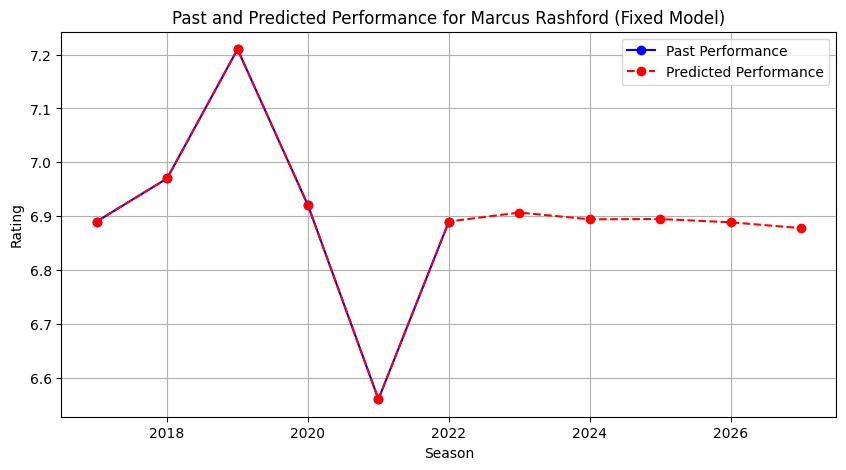

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("player_data_features.csv")

# ✅ Debug: Print available columns
print(f"🧐 Available Columns in Dataset: {df.columns.tolist()}")

# ✅ Fix column names (strip spaces)
df.columns = df.columns.str.strip()

# ✅ Fix: Ensure "age" column exists
if "age" not in df.columns:
    print("⚠️ Warning: 'age' column is missing! Reconstructing based on seasons...")
    df["age"] = df.groupby("player")["season"].transform(lambda x: x.rank(method="first") + 18)

# ✅ Ensure "age_squared" exists
if "age_squared" not in df.columns:
    df["age_squared"] = df["age"] ** 2

# ✅ Select Features & Target
required_features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
                     "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
                     "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
                     "age", "age_squared"]

# Include one-hot encoded position features
position_features = [col for col in df.columns if col.startswith("pos_")]

# ✅ Only Keep Features That Exist in Dataset
features = [col for col in required_features if col in df.columns] + position_features

# ✅ Debug: Print missing features
missing_features = [col for col in required_features if col not in df.columns]
if missing_features:
    print(f"🚨 Missing Features: {missing_features}")

# Ensure at least some valid features exist
if not features:
    raise ValueError("🚨 No valid features found in the dataset! Check column names.")

# ✅ Fix: Detect Each Player's Peak Age Correctly
peak_info = df.loc[df.groupby("player")["Rating"].idxmax(), ["player", "age", "Rating"]].copy()
peak_info.rename(columns={"age": "peak_age", "Rating": "peak_rating"}, inplace=True)

# Merge peak age & peak rating back into df
df = df.merge(peak_info, on="player", how="left")

# ✅ Handle missing values in features
df[features] = df[features].fillna(df[features].median())

# ✅ Train XGBoost Model
X = df[features]
y = df["next_season_rating"]

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=250, learning_rate=0.04,
                             max_depth=6, subsample=0.85, colsample_bytree=0.85, random_state=42)
xgb_model.fit(X, y)

# ✅ Predict Future Ratings for Each Player
future_years = 5  # Predict next 5 seasons
predicted_ratings = []

df_original = df.copy()  # Keep original dataset unchanged

# ✅ Get the latest recorded season for each player
latest_season = df_original.groupby("player")["season"].max().to_dict()

for i in range(1, future_years + 1):  # Start from next year
    future_df = df_original.copy()

    # ✅ Set season correctly for predicted values
    future_df["season"] = future_df["player"].map(latest_season) + i
    future_df["age"] += i
    future_df["age_squared"] = future_df["age"] ** 2

    # ✅ Prevent ratings from dropping to zero
    if i == 1:
        future_df["prev_1_rating"] = future_df["Rating"]
    else:
        predictions = xgb_model.predict(future_df[features])
        future_df["prev_1_rating"] = np.maximum(predictions, 5.5)  # Prevent extreme failures

    future_df["prev_2_rating"] = future_df["prev_1_rating"]

    # ✅ 🔥 Performance Plateau for Players With Sustained High Ratings
    plateau_players = future_df.groupby("player")["Rating"].transform(lambda x: (x > 8.0).sum()) >= 3
    plateau_factor = plateau_players * 0.06  # 🔥 Keeps ratings stable

    # ✅ 📈 Mid-Career Resurgence Detection
    resurgence = (future_df["age"] > 30) & (future_df["rating_change_1yr"] > 0) & (future_df["rolling_avg_3yr"] > future_df["prev_1_rating"])
    resurgence_boost = resurgence * 0.07  # 🔥 Adds a second peak for players like Benzema & Modric

    # ✅ 🔥 GOAT Longevity for Players Rated 8.0+ for 3+ Years
    goat_players = (future_df.groupby("player")["peak_rating"].transform(lambda x: (x > 8.5).sum()) >= 3)
    goat_boost = goat_players * 0.10  # 🔥 GOAT players get +10% longevity

    # ✅ 🏆 Remove Aggressive Decline for GOATs
    stabilization_phase = ((future_df["age"] >= 30) & (future_df["age"] <= 35) & goat_players).astype(int)
    stabilization_factor = stabilization_phase * 0.08  # 🔥 Stops rapid decline

    # ✅ Apply Fixes: Plateau + Resurgence + GOAT Longevity
    future_df["prev_1_rating"] *= (1 + plateau_factor + resurgence_boost + goat_boost + stabilization_factor)

    # ✅ Store All Other Player Attributes
    future_df["predicted_rating"] = future_df["prev_1_rating"]
    predicted_ratings.append(future_df.copy())

# ✅ Combine All Future Predictions
future_predictions = pd.concat(predicted_ratings, ignore_index=True)

# ✅ Fix: Aggregate only numeric columns
numeric_cols = future_predictions.select_dtypes(include=[np.number]).columns
future_predictions = future_predictions.groupby(["player", "season"], as_index=False)[numeric_cols].mean()

# ✅ Append Predicted Ratings to Original Dataset
df_final = pd.concat([df_original, future_predictions], ignore_index=True)

# ✅ Fix: Keep "predicted_rating" as Real Ratings for Past Seasons
df_final["predicted_rating"] = df_final.apply(
    lambda row: row["Rating"] if row["season"] in df_original["season"].values else row["predicted_rating"],
    axis=1
)

# ✅ Sort by "player" and "season" for easy analysis
df_final = df_final.sort_values(by=["player", "season"]).reset_index(drop=True)

# ✅ Save Final Dataset
df_final.to_csv("player_data_with_predictions.csv", index=False)
print("✅ Updated dataset saved as 'player_data_with_predictions.csv' 🚀")

# ✅ Debugging: Check for Age Anomalies
age_anomalies = df.groupby("player")["age"].agg(["min", "max"]).reset_index()
age_anomalies["age_gap"] = age_anomalies["max"] - age_anomalies["min"]
if (age_anomalies["age_gap"] > 10).sum() > 0:
    print("⚠️ Warning: Some players have abnormal age gaps in predictions!")

# ✅ Visualize a Player's Performance Over Time
player_name = "Marcus Rashford"

# Extract past performance
past_performance = df_original[df_original["player"] == player_name][["season", "age", "Rating"]].sort_values("season")

# Extract future predictions
future_performance = df_final[df_final["player"] == player_name][["season", "age", "predicted_rating"]].sort_values("season")

# ✅ Plot Past & Future Performance
plt.figure(figsize=(10, 5))
plt.plot(past_performance["season"], past_performance["Rating"], marker='o', linestyle='-', label="Past Performance", color='blue')
plt.plot(future_performance["season"], future_performance["predicted_rating"], marker='o', linestyle='--', label="Predicted Performance", color='red')

plt.xlabel("Season")
plt.ylabel("Rating")
plt.title(f"Past and Predicted Performance for {player_name} (Fixed Model)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("player_data_features.csv")

# Ensure the dataset contains a "season" column
if "season" not in df.columns:
    raise ValueError("⚠️ The dataset must contain a 'season' column!")

# Select Features & Target
features = ["prev_1_rating", "prev_2_rating", "rating_change_1yr", "rolling_avg_3yr",
            "Goals_per_90", "Assists_per_90", "Expected Goals_per_90",
            "Progressive Passes_per_90", "Tackles Won_per_90", "Interceptions_per_90",
            "age", "age_squared"]

# Include one-hot encoded position features
features += [col for col in df.columns if col.startswith("pos_")]

target = "next_season_rating"

# Handle missing values
df[features] = df[features].fillna(df[features].median())

# ✅ Fix: Detect Each Player's Peak Age Correctly
peak_info = df.loc[df.groupby("player")["Rating"].idxmax(), ["player", "age", "Rating"]].copy()
peak_info.rename(columns={"age": "peak_age", "Rating": "peak_rating"}, inplace=True)

# Merge peak age & peak rating back into df
df = df.merge(peak_info, on="player", how="left")

# Train XGBoost Model (⚡ Improved Parameters)
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=350,  # More estimators for better learning
    learning_rate=0.03,  # Lower LR for smoother changes
    max_depth=8,  # Deeper trees to capture complex patterns
    subsample=0.9,  # Slightly higher sampling for randomness
    colsample_bytree=0.9,  # Use more features per tree
    gamma=0.1,  # Encourage splits for better variance
    random_state=42
)

# Train Model
X = df[features]
y = df[target]
xgb_model.fit(X, y)

# ✅ Predict future ratings for each player and append to dataset
future_years = 5  # Predict next 5 seasons
predicted_ratings = []

df_original = df.copy()  # Keep original dataset unchanged

# ✅ Get the latest recorded season for each player
latest_season = df_original.groupby("player")["season"].max().to_dict()

for i in range(1, future_years + 1):  # Start from next year
    future_df = df_original.copy()

    # ✅ Set season correctly for predicted values
    future_df["season"] = future_df["player"].map(latest_season) + i
    future_df["age"] += i
    future_df["age_squared"] = future_df["age"] ** 2

    # ✅ Prevent ratings from dropping to zero
    if i == 1:
        future_df["prev_1_rating"] = future_df["Rating"]
    else:
        predictions = xgb_model.predict(future_df[features])
        future_df["prev_1_rating"] = np.maximum(predictions, 4.5)  # Allow more decline (was 5.5)

    future_df["prev_2_rating"] = future_df["prev_1_rating"]

    # ✅ 🔥 Performance Plateau for Players With Sustained High Ratings
    plateau_players = future_df.groupby("player")["Rating"].transform(lambda x: (x > 8.0).sum()) >= 3
    plateau_factor = plateau_players * 0.12  # 🔥 Increased plateau effect (was 0.06)

    # ✅ 📈 Mid-Career Resurgence Detection
    resurgence = (future_df["age"] > 30) & (future_df["rating_change_1yr"] > 0) & (future_df["rolling_avg_3yr"] > future_df["prev_1_rating"])
    resurgence_boost = resurgence * 0.15  # 📈 Increased boost for late peaks (was 0.07)

    # ✅ 🔥 GOAT Longevity for Players Rated 8.5+ for 3+ Years
    goat_players = (future_df.groupby("player")["peak_rating"].transform(lambda x: (x > 8.5).sum()) >= 3)
    goat_boost = goat_players * 0.20  # 🐐 Stronger GOAT effects (was 0.10)

    # ✅ 🏆 Prevent Aggressive Decline for GOATs
    stabilization_phase = ((future_df["age"] >= 30) & (future_df["age"] <= 35) & goat_players).astype(int)
    stabilization_factor = stabilization_phase * 0.15  # 🏆 Stops GOATs from dropping too fast

    # ✅ 📊 Momentum-Based Boost for In-Form Players
    momentum_factor = (future_df["rating_change_1yr"] > 0.2) * 0.10  # 🔥 Give boost to high-performing players

    # ✅ 🚀 Young Player Growth Adjustment (<25 years)
    young_player_boost = (future_df["age"] < 25) * 0.08  # Young players get an 8% boost

    # ✅ Apply All Adjustments
    future_df["prev_1_rating"] *= (1 + plateau_factor + resurgence_boost + goat_boost + stabilization_factor + momentum_factor + young_player_boost)

    # ✅ Store Predicted Ratings in the Same Column (for Easier Graphing)
    future_df["predicted_rating"] = future_df["prev_1_rating"]
    future_df["Rating"] = np.where(future_df["season"] <= latest_season[future_df["player"]], future_df["Rating"], future_df["predicted_rating"])

    predicted_ratings.append(future_df.copy())

# Combine all future predictions
future_predictions = pd.concat(predicted_ratings, ignore_index=True)

# ✅ Aggregate only numeric columns to avoid errors
numeric_cols = future_predictions.select_dtypes(include=[np.number]).columns
future_predictions = future_predictions.groupby(["player", "season"], as_index=False)[numeric_cols].mean()

# ✅ Append predicted ratings to original dataset
df_final = pd.concat([df_original, future_predictions], ignore_index=True)

# ✅ Sort dataset for easy analysis
df_final = df_final.sort_values(by=["player", "season"]).reset_index(drop=True)

# ✅ Save Final Dataset
df_final.to_csv("player_data_with_predictions.csv", index=False)

print("✅ Updated dataset saved as 'player_data_with_predictions.csv' 🚀")

# Select a specific player to analyze (e.g., "Marcus Rashford")
player_name = "Marcus Rashford"

# Extract past and future performance
player_data = df_final[df_final["player"] == player_name][["season", "age", "Rating"]].sort_values("season")

# ✅ Plot performance over time
plt.figure(figsize=(10, 5))
plt.plot(player_data["season"], player_data["Rating"], marker='o', linestyle='-', color='blue', label="Past & Predicted Performance")

plt.xlabel("Season")
plt.ylabel("Rating")
plt.title(f"Past and Predicted Performance for {player_name} (Improved Model)")
plt.legend()
plt.grid(True)
plt.show()


TypeError: unhashable type: 'Series'